# Reinforcement Learning - Policy Gradient
If you want to test/submit your solution **restart the kernel, run all cells and submit the pg_autograde.py file into codegrade.**

In [2]:
# This cell imports %%execwritefile command (executes cell and writes it into file). 
from custommagics import CustomMagics
get_ipython().register_magics(CustomMagics)

In [3]:
%%execwritefile pg_autograde.py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

Overwriting pg_autograde.py


In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import sys

import gym
import time

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

---

## 3. Policy Gradient

### 3.1 Policy Network

In order to implement policy gradient, we will first implement a class with a policy network. Although in general this does not have to be the case, we will use an architecture very similar to the Q-network that we used (two layers with ReLU activation for the hidden layer). Since we have discrete actions, our model will output one value per action, where each value represents the (normalized!) probability of selecting that action. *Use the softmax activation function.*

In [5]:
%%execwritefile -a pg_autograde.py

class NNPolicy(nn.Module):
    
    def __init__(self, num_hidden=128, in_size=4, out_size=2):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(in_size, num_hidden)
        self.l2 = nn.Linear(num_hidden, out_size)

    def forward(self, x):
        """
        Performs a forward pass through the network.
        
        Args:
            x: input tensor (first dimension is a batch dimension)
            
        Return:
            Probabilities of performing all actions in given input states x. Shape: batch_size x action_space_size
        """
        # YOUR CODE HERE
        output = self.l1(x)
        output = F.relu(output)
        output = self.l2(output)
        output = F.softmax(output,dim=-1)
        return output
        
    def get_probs(self, obs, actions):
        """
        This function takes a tensor of states and a tensor of actions and returns a tensor that contains 
        a probability of perfoming corresponding action in all states (one for every state action pair). 

        Args:
            obs: a tensor of states. Shape: batch_size x obs_dim
            actions: a tensor of actions. Shape: batch_size x 1

        Returns:
            A torch tensor filled with probabilities. Shape: batch_size x 1.
        """
        # YOUR CODE HERE
        output = self.forward(obs)
        action_probs = output.gather(dim=-1,index=actions)
        return action_probs
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: state as a tensor. Shape: 1 x obs_dim or obs_dim

        Returns:
            An action (int).
        """
        # YOUR CODE HERE
        output = self.forward(obs)
        # Convert into tensor.
        actions = torch.ShortTensor(np.arange(0,output.size(0)))
        # Use torch.multinomial to sample action given the action probs.
        idx = output.multinomial(num_samples=1, replacement=True)
        action = actions[idx].item()
        return action
        
        

Appending to pg_autograde.py


In [6]:
# Let's instantiate and test if it works
num_hidden = 128
torch.manual_seed(1234)
policy = NNPolicy(num_hidden)

states = torch.rand(10, 4)
actions = torch.randint(low=0, high=2, size=(10,1))
print(actions)

# Does the outcome make sense?
forward_probs = policy.forward(states)
assert forward_probs.shape == (10,2), "Output of forward has incorrect shape."
sampled_action = policy.sample_action(states[0])
assert sampled_action == 0 or sampled_action == 1, "Output of sample action is not 0 or 1"

action_probs = policy.get_probs(states, actions)
print(action_probs)
assert action_probs.shape == (10,1), "Output of get_probs has incorrect shape."

tensor([[0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0]])
tensor([[0.4578],
        [0.5343],
        [0.5437],
        [0.4634],
        [0.4564],
        [0.5275],
        [0.4769],
        [0.5166],
        [0.4797],
        [0.4618]], grad_fn=&lt;GatherBackward&gt;)


### 3.2 Monte Carlo REINFORCE

Now we will implement the *Monte Carlo* policy gradient algorithm. Remember that this means that we will estimate returns for states by sample episodes. Compared to DQN, this means that we do *not* perform an update step at every environment step, but only at the end of each episode. This means that we should generate an episode of data, compute the REINFORCE loss (which requires computing the returns) and then perform a gradient step.

* You can use `torch.multinomial` to sample from a categorical distribution.
* The REINFORCE loss is defined as $- \sum_t \log \pi_\theta(a_t|s_t) G_t$, which means that you should compute the (discounted) return $G_t$ for all $t$. Make sure that you do this in **linear time**, otherwise your algorithm will be very slow! Note the - (minus) since you want to maximize return while you want to minimize the loss.

To help you, we wrote down signatures of a few helper functions. Start by implementing a sampling routine that samples a single episode (similarly to the one in Monte Carlo lab).

In [7]:
%%execwritefile -a pg_autograde.py

def sample_episode(env, policy, render=False):
    """
    A sampling routine. Given environment and a policy samples one episode and returns states, actions, rewards
    and dones from environment's step function as tensors.

    Args:
        env: OpenAI gym environment.
        policy: A policy which allows us to sample actions with its sample_action method.

    Returns:
        Tuple of tensors (states, actions, rewards, dones). All tensors should have same first dimension and 
        should have dim=2. This means that vectors of length N (states, rewards, actions) should be Nx1.
        Hint: Do not include the state after termination in states.
    """
    states = []
    actions = []
    rewards = []
    dones = []
    
    # YOUR CODE HERE
    done = False
    state = env.reset()
    while not done:
        # Get action using policy.
        action = policy.sample_action(torch.Tensor(state))#.item() 
        next_state, reward, done, _ = env.step(action)
        if render:
            env.render()
        # Append to lists
        states.append(state), actions.append(action), rewards.append(reward), dones.append(done)
        # Update to next state.
        state = next_state

    states, actions, rewards = torch.Tensor(states), torch.LongTensor(actions).unsqueeze(dim=1), torch.Tensor(rewards).unsqueeze(dim=1)
    dones = torch.Tensor(dones).unsqueeze(dim=1)

    return states, actions, rewards, dones

Appending to pg_autograde.py


In [8]:
# Let's sample some episodes
env = gym.envs.make("CartPole-v1")
num_hidden = 128
torch.manual_seed(1234)
policy = NNPolicy(num_hidden)
for episode in range(3):
    trajectory_data = sample_episode(env, policy)

Now implement loss computation and training loop of the algorithm.

In [9]:
%%execwritefile -a pg_autograde.py

def compute_reinforce_loss(policy, episode, discount_factor):
    """
    Computes reinforce loss for given episode.

    Args:
        policy: A policy which allows us to get probabilities of actions in states with its get_probs method.

    Returns:
        loss: reinforce loss
    """
    # Compute the reinforce loss
    # Make sure that your function runs in LINEAR TIME
    # Note that the rewards/returns should be maximized 
    # while the loss should be minimized so you need a - somewhere
    
    # YOUR CODE HERE
    states, actions, rewards, dones = episode

    # Calculate rewards.
    rewards = rewards.squeeze()
    G = torch.zeros_like(rewards)
    # Need to calculate loss using formula G_{t+1} = r_t + \gamma G_{t+1}
    # If statement makes sure that there isn't an error when t=0. Otherwise, we'd get an error 
    #  since there's no negative time step.
    for t in reversed(range(rewards.shape[0])):
        G[t] = rewards[t] + ((discount_factor * G[t+1]) if t+1<rewards.shape[0] else 0)
    
    # Calculate loss.
    action_probs = torch.log(policy.get_probs(states, actions)).squeeze()
    loss = - (action_probs * G).sum()
    return loss

def run_episodes_policy_gradient(policy, env, num_episodes, discount_factor, learn_rate, 
                                 sampling_function=sample_episode, render=False):
    optimizer = optim.Adam(policy.parameters(), learn_rate)
    
    episode_durations, losses, cum_rewards = [], [], []
    for i in range(num_episodes):
        # YOUR CODE HERE
        episode = sample_episode(env, policy, render=render)
        loss = compute_reinforce_loss(policy, episode, discount_factor)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                           
        if i % 10 == 0:
            print("{2} Episode {0} finished after {1} steps"
                  .format(i, len(episode[0]), '\033[92m' if len(episode[0]) >= 195 else '\033[99m'))
        episode_durations.append(len(episode[0]))
        losses.append(float(loss))
        cum_rewards.append(sum(episode[2]))
        
    return episode_durations, losses, cum_rewards

Appending to pg_autograde.py


In [10]:
# Smoothing function for nicer plots
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [11]:
env = gym.envs.make("LunarLander-v2")
env.step?

Signature: env.step(action)
Docstring:
Run one timestep of the environment&#39;s dynamics. When end of
episode is reached, you are responsible for calling `reset()`
to reset this environment&#39;s state.

Accepts an action and returns a tuple (observation, reward, done, info).

Args:
    action (object): an action provided by the environment

Returns:
    observation (object): agent&#39;s observation of the current environment
    reward (float) : amount of reward returned after previous action
    done (boolean): whether the episode has ended, in which case further step() calls will return undefined results
    info (dict): contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)
File:      ~/anaconda3/envs/rl2020/lib/python3.7/site-packages/gym/wrappers/time_limit.py
Type:      method


ed after 1000 steps
 Episode 5530 finished after 161 steps
 Episode 5540 finished after 170 steps
 Episode 5550 finished after 1000 steps
 Episode 5560 finished after 1000 steps
 Episode 5570 finished after 1000 steps
 Episode 5580 finished after 134 steps
 Episode 5590 finished after 1000 steps
 Episode 5600 finished after 202 steps
 Episode 5610 finished after 1000 steps
 Episode 5620 finished after 1000 steps
 Episode 5630 finished after 276 steps
 Episode 5640 finished after 1000 steps
 Episode 5650 finished after 1000 steps
 Episode 5660 finished after 452 steps
 Episode 5670 finished after 1000 steps
 Episode 5680 finished after 1000 steps
 Episode 5690 finished after 1000 steps
 Episode 5700 finished after 1000 steps
 Episode 5710 finished after 1000 steps
 Episode 5720 finished after 1000 steps
 Episode 5730 finished after 1000 steps
 Episode 5740 finished after 1000 steps
 Episode 5750 finished after 1000 steps
 Episode 5760 finished after 1000 steps
 Episode 5770 finished aft

&lt;matplotlib.legend.Legend at 0x7f434e044ac8&gt;

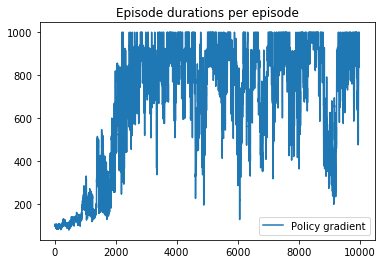

In [12]:
# Feel free to play around with the parameters!
num_episodes = 10000
discount_factor = 0.99
learn_rate = 0.001
seed = 42
num_actions = 4

env = gym.envs.make("LunarLander-v2")
torch.manual_seed(seed)
env.seed(seed)
policy = NNPolicy(num_hidden, len(env.reset()), num_actions)

episode_durations_policy_gradient, losses, cum_rewards = run_episodes_policy_gradient(
    policy, env, num_episodes, discount_factor, learn_rate)

plt.plot(smooth(episode_durations_policy_gradient, 10))
plt.title('Episode durations per episode')
plt.legend(['Policy gradient'])

&lt;matplotlib.legend.Legend at 0x7f434e00ceb8&gt;

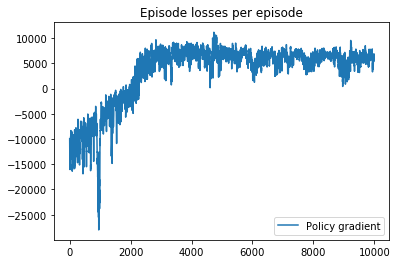

In [13]:
plt.plot(smooth(losses, 10))
plt.title('Episode losses per episode')
plt.legend(['Policy gradient'])

&lt;matplotlib.legend.Legend at 0x7f434dfbc0f0&gt;

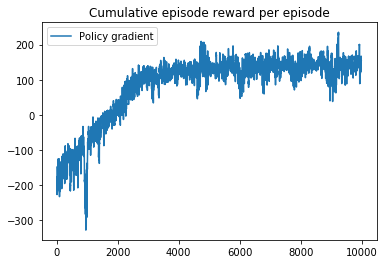

In [14]:
plt.plot(smooth(cum_rewards, 10))
plt.title('Cumulative episode reward per episode')
plt.legend(['Policy gradient'])